In [1]:
import spkit as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import mne
from copy import deepcopy
from mne.preprocessing import compute_proj_ecg
from mne_connectivity import envelope_correlation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import random
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
import autoreject
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from autoreject import Ransac
from mne.preprocessing import annotate_amplitude
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

In [2]:
def Load_Raw(path, sfreq = 300, plot_raw = False):
    data = np.array(pd.read_csv(path, skiprows=2))

    data = np.delete(data, [0, 1, -1, -3, -4], axis=1)
    #data = np.delete(data, [0, 1, -1], axis=1)


    #ch_name = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1', 'ECG']
    channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'ECG']
    #ch_name = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1']

    X = deepcopy(data)
    X = deepcopy(X[10000:-10000])

    sfreq = 300
    info = mne.create_info(channel_names, sfreq, ch_types=['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'ecg'])
    raw = mne.io.RawArray(X.T, info);
    raw.set_montage('standard_1020')

    if(plot_raw):
        raw.plot(scalings='auto');

    return raw


In [3]:
def Artifact_Correction(raw, plot_source=False):
    ica = ICA(n_components=21, max_iter="auto", random_state=97)
    ica.fit(raw)

    explained_var_ratio = ica.get_explained_variance_ratio(raw)
    for channel_type, ratio in explained_var_ratio.items():
        print(
            f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
        )

    raw.load_data()
    if(plot_source):
        ica.plot_sources(raw, show_scrollbars=False);
    
    n_max_ecg = 15  
    ecg_epochs = create_ecg_epochs(raw, tmin=-.3, tmax=.3)
    #ecg_epochs.decimate(5).apply_baseline((None, None))
    ecg_inds, scores_ecg = ica.find_bads_ecg(ecg_epochs, threshold='auto', method='correlation')
    print('Found %d ECG component(s)' % (len(ecg_inds),))
    ica.exclude += ecg_inds[:n_max_ecg]
    ica.plot_scores(scores_ecg, exclude=ecg_inds, title='ECG scores');


    print(ica.exclude)
    ica.apply(raw, exclude=ica.exclude)

    bad_segments = annotate_amplitude(raw, peak=5, flat=0.5, min_duration=0.5)
    raw.set_annotations(bad_segments[0])
    
    epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True, overlap= 1)

    return epochs

In [4]:
def Reject_Bad_Epochs(epochs):
    ar = AutoReject()
    new_epochs = ar.fit_transform(epochs, random)
    return new_epochs

In [5]:
def Bipolar(new_epochs):
    anode = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6']
    cathode = ['F3', 'F8', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']
    bipolar_data = mne.set_bipolar_reference(new_epochs[0], anode, cathode);
    
    return bipolar_data

In [6]:
mne.set_config("MNE_USE_CUDA", "True")
mne.cuda.init_cuda()

Now using CUDA device 0
Enabling CUDA with 7.02 GB available memory


In [14]:
path = "K:\Clean Data\IGE\shirband\samples.csv"
name = 'shirband'
raw = Load_Raw(path);

Creating RawArray with float64 data, n_channels=22, n_times=1795746
    Range : 0 ... 1795745 =      0.000 ...  5985.817 secs
Ready.


Fitting ICA to data using 21 channels (please be patient, this may take a while)


C:\Users\Ozzy\AppData\Local\Temp\ipykernel_2688\2675175726.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.


Selecting by number: 21 components
Fitting ICA took 42.6s.
Fraction of eeg variance explained by all components: 1.0
Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 3000 samples (10.000 s)

Number of ECG events detected : 7655 (average pulse 76 / min.)
Not setting metadata
7655 matching events found
No baseline correction applied
Using data from preloaded Raw for 7655 events and 181 original time points ...
0 bad epochs dropped
Found 2 ECG component(s)


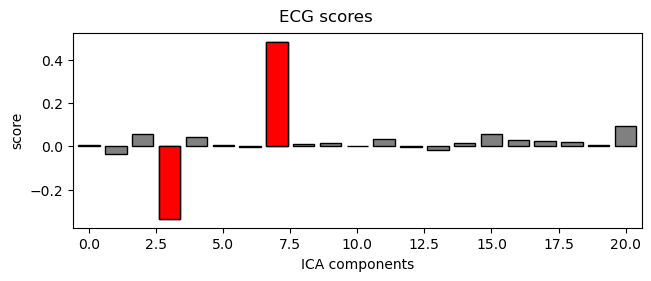

[7, 3]
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 2 ICA components
    Projecting back using 21 PCA components
Finding segments below or above PTP threshold.
Not setting metadata
664 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 664 events and 3000 original time points ...
1 bad epochs dropped


In [8]:
epochs = Artifact_Correction(raw)

In [9]:
new_epochs = Reject_Bad_Epochs(epochs)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/21 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/21 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/663 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/663 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/663 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/663 [00:00<?,       ?it/s]

c:\Users\Ozzy\anaconda3\lib\site-packages\mne\bem.py:1134: RuntimeWarning: Mean of empty slice.
c:\Users\Ozzy\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
c:\Users\Ozzy\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
c:\Users\Ozzy\anaconda3\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=20


  0%|          | Repairing epochs : 0/663 [00:00<?,       ?it/s]

Dropped 27 epochs: 143, 157, 161, 162, 174, 238, 258, 270, 279, 280, 381, 398, 405, 410, 433, 449, 546, 604, 614, 618, 622, 624, 633, 634, 636, 637, 639


In [11]:
bipolar_data = Bipolar(new_epochs)

EEG channel type selected for re-referencing
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated
Added the following bipolar channels:
Fp1-F3, Fp2-F8, F3-C3, F4-C4, C3-P3, C4-P4, P3-O1, P4-O2, F7-T3, F8-T4, T3-T5, T4-T6, T5-O1, T6-O2


In [15]:
bipolar_data.save(name + ".fif", overwrite=True)
#bipolar_data_from_file = mne.read_epochs("test.fif", preload=False)

C:\Users\Ozzy\AppData\Local\Temp\ipykernel_2688\2609673607.py:1: RuntimeWarning: This filename (shirband.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz


In [16]:
"""
#bipolar_data = mne.set_bipolar_reference(new_epochs[0], anode, cathode);
bipolar_data = bipolar_data.get_data(picks='eeg')
#scaler = mne.decoding.Scaler(info = info, scalings=None)


#bipolar_data = bipolar_data.reshape(-1, 3000, 20)
pre = bipolar_data[141]
scaler = StandardScaler()


post = scaler.fit_transform(pre)

normals = []
scaler = StandardScaler()
for idx in range(len(bipolar_data)):
    normals.append(scaler.fit_transform(bipolar_data[idx]))
normals = np.array(normals)


normals.shape
"""